In this notebook, I will publish some code examples for training AlexNet, using Keras and Theano.

**Software Requirements :- **
1. Theano - Follow the instructions available here http://deeplearning.net/software/theano/install.html#install
2. Keras - Follow the instructions available here https://keras.io/#installation

**We will acheive 3 objectives - **
1. Establish the baseline performance of AlexNet on our classification task
2. Train a basic ANN/SVM as a classifier, using the features extracted from a pre-trained AlexNet model
3. Fine-Tune the layers of the AlexNet model

In [1]:
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from alexnet_base import *
from utils import *

Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '22535' (I am process '24494')
Using gpu device 1: Tesla K20m (CNMeM is disabled, cuDNN 5103)
/home/rahulduggal2608/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Define some variables

In [2]:
batch_size = 16
input_size = (3,227,227)
nb_classes = 2
mean_flag = True # if False, then the mean subtraction layer is not prepended

In the cell below, we define generators which are neat ways to perform realtime data augmentation. We use only basic data augmentation such as shear, zoom and flipping.

In [3]:
#code ported from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        '../Data/Train',  
        batch_size=batch_size,
        shuffle=True,
        target_size=input_size[1:],
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '../Data/Test',  
        batch_size=batch_size,
        target_size=input_size[1:],
        shuffle=True,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Task 1 : Training AlexNet from scratch

Ontain the AlexNet model object. The get_alexnet function abstracts two things
    1. Implements real-time mean subtraction through prepending a custom layer
    2. Specifies the initialization parameter of each layer to he_normal

In [4]:
alexnet = get_alexnet(input_size,nb_classes,mean_flag)
    
print alexnet.summary()

/home/rahulduggal2608/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer mean_subtraction and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 227, 227)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 227, 227)   0                                            
____________________________________________________________________________________________________
mean_subtraction (Lambda)        (None, 3, 227, 227)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 96, 55, 55)    34944       mean_subtraction[0][0]           
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 96, 27, 27)    0           conv_1[0][0]                     
___________________________________________________________________________________________

We train the AlexNet CNN using Stochastic Gradient descent for 80 epochs.

In [5]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alexnet.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy'])

history = alexnet.fit_generator(train_generator,
                        samples_per_epoch=2000,
                        validation_data=validation_generator,
                        nb_val_samples=800,
                        nb_epoch=80,
                        verbose=1)

Epoch 1/80
2000/2000 [==============================] - 45s - loss: 0.2601 - acc: 0.5410 - val_loss: 0.2468 - val_acc: 0.5513
Epoch 2/80
2000/2000 [==============================] - 42s - loss: 0.2386 - acc: 0.5940 - val_loss: 0.2248 - val_acc: 0.6312
Epoch 3/80
2000/2000 [==============================] - 42s - loss: 0.2315 - acc: 0.6200 - val_loss: 0.2173 - val_acc: 0.6450
Epoch 4/80
2000/2000 [==============================] - 43s - loss: 0.2202 - acc: 0.6530 - val_loss: 0.2127 - val_acc: 0.6637
Epoch 5/80
2000/2000 [==============================] - 44s - loss: 0.2122 - acc: 0.6775 - val_loss: 0.2001 - val_acc: 0.6975
Epoch 6/80
2000/2000 [==============================] - 44s - loss: 0.1983 - acc: 0.6940 - val_loss: 0.1892 - val_acc: 0.7200
Epoch 7/80
2000/2000 [==============================] - 42s - loss: 0.1905 - acc: 0.7175 - val_loss: 0.1857 - val_acc: 0.7225
Epoch 8/80
2000/2000 [==============================] - 41s - loss: 0.1812 - acc: 0.7360 - val_loss: 0.1794 - val_acc:

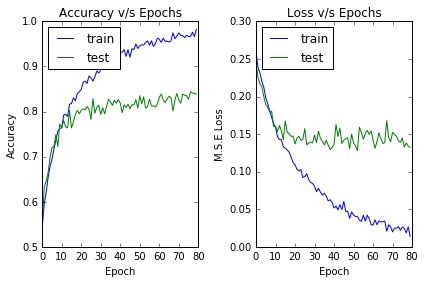

In [6]:
plot_performance(history)

**Discussion**

The standard AlexNet, trained from scratch obtains ~84% accuracy. The accuracy and loss plots shown above suggest overfitting. In the next section, we will try to overcome this problem through fine-tuning.

### Task 2 : Fine-Tuning Alexnet

We will follow the strategy as suggested in this paper - http://ieeexplore.ieee.org/abstract/document/7426826/?reload=true

The basic idea is to perform the training layerwise. What this means is - consider a 5 layer CNN with layers {L1,L2,L3,L4,L5}. In the first round of training, we freeze layers L1-L4 and finetune layer L5 for some epochs. In the next round, we train layers L4,L5 for some epochs. In the next round, we train L3,L4,L5 for some epochs. Essentially, the training percolates to shallow layers.

In [4]:
alexnet = get_alexnet(input_size,nb_classes,mean_flag)
alexnet.load_weights('../convnets-keras/weights/alexnet_weights.h5', by_name=True)

print alexnet.summary()

/home/rahulduggal2608/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer mean_subtraction and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 227, 227)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 227, 227)   0                                            
____________________________________________________________________________________________________
mean_subtraction (Lambda)        (None, 3, 227, 227)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 96, 55, 55)    34944       mean_subtraction[0][0]           
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 96, 27, 27)    0           conv_1[0][0]                     
___________________________________________________________________________________________

In [5]:
layers = ['dense_3_new','dense_2','dense_1','conv_5_1','conv_4_1','conv_3','conv_2_1','conv_1']
epochs = [10,10,10,10,10,10,10,10]
lr = [1e-2,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]

history_finetune = []

for i,layer in enumerate(layers):
        
    alexnet = unfreeze_layer_onwards(alexnet,layer)    
   
    sgd = SGD(lr=lr[i], decay=1e-6, momentum=0.9, nesterov=True)
    alexnet.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy'])
    
    for epoch in range(epochs[i]):    
        h = alexnet.fit_generator(train_generator,
                                        samples_per_epoch=2000,
                                        validation_data=validation_generator,
                                        nb_val_samples=800,
                                        nb_epoch=1,
                                        verbose=1)
        
        history_finetune = append_history(history_finetune,h)

Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.2274 - acc: 0.6335 - val_loss: 0.2005 - val_acc: 0.6913
Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.2000 - acc: 0.6945 - val_loss: 0.1931 - val_acc: 0.7100
Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.1968 - acc: 0.6915 - val_loss: 0.1815 - val_acc: 0.7362
Epoch 1/1
2000/2000 [==============================] - 46s - loss: 0.1969 - acc: 0.7020 - val_loss: 0.1773 - val_acc: 0.7475
Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.1918 - acc: 0.7130 - val_loss: 0.1755 - val_acc: 0.7500
Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.1877 - acc: 0.7205 - val_loss: 0.1697 - val_acc: 0.7588
Epoch 1/1
2000/2000 [==============================] - 46s - loss: 0.1853 - acc: 0.7135 - val_loss: 0.1651 - val_acc: 0.7750
Epoch 1/1
2000/2000 [==============================] - 47s - loss: 0.1881 - acc: 0.7205 - val_loss: 0.1602 - val_acc: 0.7762


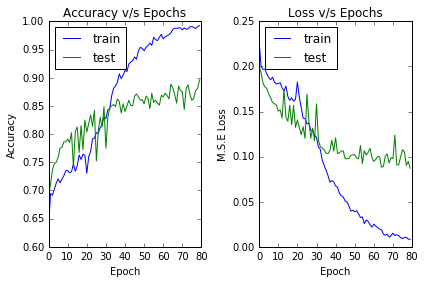

In [6]:
plot_performance(history_finetune)

**Discussion**

We get a test accuracy of ~89%. This is almost a 5% jump over the training from scratch case. This is a huge jump in test accuracy! One should not expect such a bug jump usually. We should bear in mind that the ImageNet dataset, on which AlexNet was pre-trained already contained dogs and cats among its classes. However, many papers report benefits of fine-tuning over training from scratch.

### Task 3 : Using AlexNet as a feature extractor

We treat the activation maps from outout of the last convolutional layer as dense feature maps. These are flattened and fed into a single layer ANN consisting of 256 neurons.

In the cell below, we get a sliced CNN model (alexnet_convolutional_only) which will enable us to extract features from any layer specified by its name ("convpool_5" in our case)

In [7]:
alexnet = get_alexnet(input_size,nb_classes,mean_flag)
alexnet.load_weights('../convnets-keras/weights/alexnet_weights.h5', by_name=True)

alexnet_convolutional_only = Model(input=alexnet.input, output=alexnet.get_layer('convpool_5').output)    

Get the output of the sliced CNN model

In [9]:
#code ported from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import numpy as np

generator = train_datagen.flow_from_directory(
        '../Data/Train',
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
train_data = alexnet_convolutional_only.predict_generator(generator, 2000)
train_labels = np.array([[1, 0]] * 1000 + [[0, 1]] * 1000)

generator = test_datagen.flow_from_directory(
        '../Data/Test',
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_data = alexnet_convolutional_only.predict_generator(generator, 800)
validation_labels = np.array([[1,0]] * 400 + [[0,1]] * 400)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


We define and train a single layer ANN model with 256 neurons

In [10]:
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='mse',
              metrics=['accuracy'])

history_convpool_5 = model.fit(train_data, train_labels,
                      nb_epoch=80,
                      batch_size=batch_size,
                      validation_data=(validation_data, validation_labels),
                      verbose=2)

Train on 2000 samples, validate on 800 samples
Epoch 1/80
0s - loss: 0.2403 - acc: 0.6190 - val_loss: 0.1720 - val_acc: 0.7625
Epoch 2/80
0s - loss: 0.1821 - acc: 0.7230 - val_loss: 0.1565 - val_acc: 0.7925
Epoch 3/80
0s - loss: 0.1664 - acc: 0.7550 - val_loss: 0.1502 - val_acc: 0.8000
Epoch 4/80
0s - loss: 0.1528 - acc: 0.7830 - val_loss: 0.1508 - val_acc: 0.7987
Epoch 5/80
0s - loss: 0.1464 - acc: 0.7950 - val_loss: 0.1425 - val_acc: 0.8063
Epoch 6/80
0s - loss: 0.1350 - acc: 0.8210 - val_loss: 0.1418 - val_acc: 0.8025
Epoch 7/80
0s - loss: 0.1263 - acc: 0.8325 - val_loss: 0.1373 - val_acc: 0.8125
Epoch 8/80
0s - loss: 0.1181 - acc: 0.8425 - val_loss: 0.1354 - val_acc: 0.8125
Epoch 9/80
0s - loss: 0.1093 - acc: 0.8550 - val_loss: 0.1371 - val_acc: 0.8187
Epoch 10/80
0s - loss: 0.1027 - acc: 0.8670 - val_loss: 0.1472 - val_acc: 0.7887
Epoch 11/80
0s - loss: 0.0969 - acc: 0.8755 - val_loss: 0.1527 - val_acc: 0.7762
Epoch 12/80
0s - loss: 0.0923 - acc: 0.8795 - val_loss: 0.1466 - val_ac

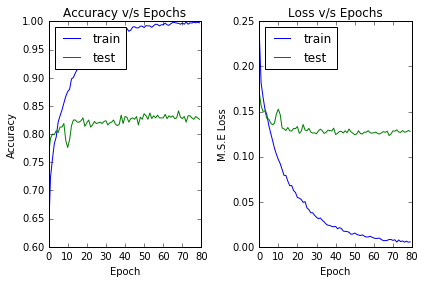

In [11]:
plot_performance(history_convpool_5)

** Discussion**
We obtain a classification accuracy of ~84 which seems at par with the accuracy obtained while training from scratch. The model converges in very few epochs.